In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
%matplotlib inline

$$
\begin{cases}
H_0: P_{con} = P_{exp} \\
H_1: P_{con} \neq P_{exp}
\end{cases}
$$

$$
\begin{aligned}
\text{con } = \text{Control Group} \\ \text{exp } = \text{Experimental Group}
\end{aligned}
$$

In [ ]:
# Load The Data From CSV File
df_ab_test = pd.read_csv("ab_test_click_data.csv")

In [15]:
# Display The First Few Rows Of The DataFrame
df_ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


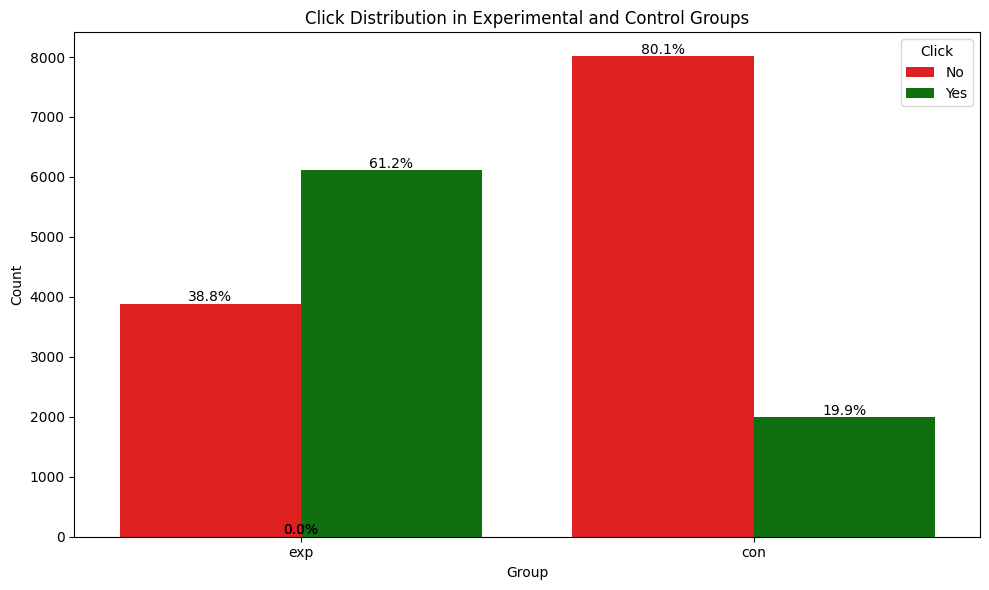

In [20]:
# Custom Palette For Yellow And Black
palette = {0: "red", 1:"green"} # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt. figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title( 'Click Distribution in Experimental and Control Groups')
plt.xlabel ( 'Group')
plt.ylabel ('Count' )
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate une percentades and annotate the bars
group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group','click']).size().reset_index(name='count')
for p in ax.patches:
  height = p.get_height()
  #rand the group and click type or the current bar
  group = 'exp' if p.get_x() < 0.5 else 'con'
  Click = 1 if p.get_x() % 1 > 0.5 else 0
  total = group_counts.loc[group]
  percentage = 100 * height / total
  ax.text(p.get_x() + p.get_width() / 2., height + 40, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout ()
plt.show()

**Parameters of the Model from Power Analysis**

- $\beta$: Probability of Type II Error  
- $(1 - \beta)$: Power of the test  
- $\alpha$: Probability of Type I Error, Significance Level  
- $\delta$: Minimum Detectable Effect

In [22]:
# Statistical significance level of the test
alpha = 0.05 # 5%
print("Alpha: significance level is:", alpha )

# Minimum Detectable Effect
delta = 0.1 # 10%
print("Delta: Minimum Detectable Effect is:", delta )

Alpha: significance level is: 0.05
Delta: Minimum Detectable Effect is: 0.1


In [41]:
# Calculating the total number of clicks per group by summing 1's
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# Printing this for visibility
print("Number of CLicks in Control: ", X_con)
print("Number of CLicks in Experimental: ", X_exp)

Number of CLicks in Control:  1989
Number of CLicks in Experimental:  6116


$$
\hat{p}_{con} = \frac{X_{con}}{N_{con}} = \frac{\#clicks_{con}}{\#impressions_{con}}
$$

$$
\hat{p}_{exp} = \frac{X_{exp}}{N_{exp}} = \frac{\#clicks_{exp}}{\#impressions_{exp}}
$$

**Where:**
- $\hat{p}_{con}$: Estimated proportion for control group
- $\hat{p}_{exp}$: Estimated proportion for experimental group
- $\#clicks$: Number of clicks
- $\#impressions$: Number of impressions

In [43]:
# Computing the estimate of click probability per group
N_con = df_ab_test.groupby(['group']).size().loc["con"]
N_exp = df_ab_test.groupby(['group']).size().loc["exp"]
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

Click Probability in Control Group: 0.1989
Click Probability in Experimental Group: 0.6116


$$
\hat{p}_{pooled} = \frac{X_{con} + X_{exp}}{N_{con} + N_{exp}} = \frac{\#clicks_{con} + \#clicks_{exp}}{\#impressions_{con} + \#impressions_{exp}}
$$

$$
s^2_{pooled} = \hat{p}_{pooled}(1 - \hat{p}_{pooled}) \times \left(\frac{1}{N_{con}} + \frac{1}{N_{exp}}\right)
$$

In [45]:
# Computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)

# Computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  0.40525
pooled_variance is:  4.82044875e-05


## Two-Sample Z-Test Formulas

### 1. Standard Error
$$
SE = \sqrt{\hat{p}_{pooled}(1 - \hat{p}_{pooled}) \cdot \left(\frac{1}{N_{con}} + \frac{1}{N_{exp}}\right)}
$$

### 2. Test Statistic
$$
Z = \frac{\hat{p}_{con} - \hat{p}_{exp}}{SE}
$$

### 3. Critical Value
$$
Z_{\text{critical}} = \Phi^{-1}\left(1 - \frac{\alpha}{2}\right)
$$

where:
- $Z_{\text{critical}}$ = Critical value from standard normal distribution
- $\Phi^{-1}$ = Inverse cumulative distribution function (ppf)
- $\alpha$ = Significance level

### 4. Decision Rule:
- If $|Z| > Z_{\text{critical}}$, reject $H_0$
- If $|Z| \leq Z_{\text{critical}}$, fail to reject $H_0$

In [47]:
# Computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# Computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

# Critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054


$$
p\text{-value} = 2 \times [1 - \Phi(|Z_{test}|)]
$$

where:
- $\Phi$ = Cumulative distribution function of standard normal

In [51]:
# Calculating p value
p_value = 2 * norm.sf(abs(Test_stat))
print("P-value of the 2-sample Z-test: ",round(p_value,3))

P-value of the 2-sample Z-test:  0.0


In [54]:
# Function to check statistical significance
def is_statistical_significance(p_value, alpha=0.05):
    """
    Assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
      - p_value (float): The p-value resulting from a statistical test.
      - alpha (float, optional): The significance level threshold used to determine statistical significance.
                                 Defaults to 0.05.

    Returns:
      - None. Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the test: {round(p_value, 3)}")

    # Determine statistical significance
    if p_value <= alpha:
        print("The result is statistically significant, suggesting that the observed differences between groups are unlikely due to chance.")
    else:
        print("The result is not statistically significant, indicating that the observed differences could be explained by random variation.")
is_statistical_significance(p_value, alpha=0.05)

P-value of the test: 0.0
The result is statistically significant, suggesting that the observed differences between groups are unlikely due to chance.


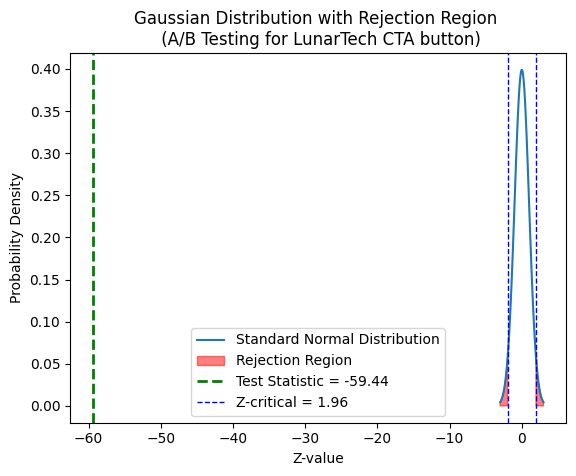

In [58]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')

# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')

# Adding Test Statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')

# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.legend()

# Show plot
plt.show()

$$
CI = \left[(\hat{p}_{exp} - \hat{p}_{con}) - SE \times Z_{\text{critical}},\ (\hat{p}_{exp} - \hat{p}_{con}) + SE \times Z_{\text{critical}}\right]
$$

where:
- $\hat{p}_{exp} - \hat{p}_{con}$ = Observed difference in proportions
- $SE$ = Standard Error
- $Z_{\text{critical}}$ = Critical value from standard normal distribution

In [61]:
# Confidence Interval of the 2 sample Z-test
CI = [round((p_exp_hat - p_con_hat) - SE*Z_crit,3), round((p_exp_hat - p_con_hat) + SE*Z_crit,3)]
print("Confidence Interval of the 2 sample Z-test is: ", CI)

Confidence Interval of the 2 sample Z-test is:  [np.float64(0.399), np.float64(0.426)]
